**DBN (Stacked of RBM) with CNN**

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Directory containing .mp3 files
AUDIO_DIR = "/kaggle/input/nepali-mp3/new" 

# Parameters
SAMPLE_RATE = 22050  # Target sample rate for audio signals
DURATION = 10  # Duration of audio to load (in seconds)
N_COMPONENTS = 64  # Number of hidden units in the RBM
LEARNING_RATE = 0.01  # Learning rate for RBM
N_ITER = 10  # Number of iterations for RBM training
BATCH_SIZE = 32  # Batch size for RBM training
EPOCHS = 50  # Number of epochs for CNN training
CNN_BATCH_SIZE = 32  # Batch size for CNN training
TEST_SIZE = 0.2  # Percentage of data to use for testing
VAL_SIZE = 0.2  # Percentage of training data to use for validation

In [3]:
# Function to load and preprocess audio signals
def load_audio_signals(directory, sample_rate, duration):
    signals = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            # Extract genre from filename (e.g., "dohori_1.wav" -> "dohori")
            genre = filename.split("_")[0]
            filepath = os.path.join(directory, filename)

            # Load audio file
            signal, _ = librosa.load(filepath, sr=sample_rate, duration=duration)

            # Pad or truncate signal to fixed length
            if len(signal) < sample_rate * duration:
                signal = np.pad(signal, (0, sample_rate * duration - len(signal)))
            else:
                signal = signal[:sample_rate * duration]

            signals.append(signal)
            labels.append(genre)

    return np.array(signals), np.array(labels)

# Load and preprocess audio signals
print("Loading and preprocessing audio signals...")
signals, labels = load_audio_signals(AUDIO_DIR, SAMPLE_RATE, DURATION)
print(f"Signals shape: {signals.shape}, Labels shape: {labels.shape}")

Loading and preprocessing audio signals...
Signals shape: (7000, 220500), Labels shape: (7000,)


In [4]:
# Normalize signals to [0, 1] range
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_signals = scaler.fit_transform(signals)
print(f"Normalized signals shape: {normalized_signals.shape}")

Normalized signals shape: (7000, 220500)


In [5]:
# Function to train a stack of RBMs (DBN)
def train_dbn(data, n_layers, n_components, learning_rate, batch_size, n_iter):
    dbn_features = data
    rbm_stack = []

    for i in range(n_layers):
        print(f"Training RBM layer {i + 1}...")
        rbm = BernoulliRBM(
            n_components=n_components,
            learning_rate=learning_rate,
            batch_size=batch_size,
            n_iter=n_iter,
            verbose=True
        )
        dbn_features = rbm.fit_transform(dbn_features)  # Extract features for next layer
        rbm_stack.append(rbm)  # Save the trained RBM
        print(f"RBM layer {i + 1} features shape: {dbn_features.shape}")

    return dbn_features, rbm_stack

# Train the DBN with a stack of RBMs
print("Training DBN with stacked RBMs...")
dbn_features, rbm_stack = train_dbn(
    data=normalized_signals,  # Use normalized signals directly
    n_layers=3,               # Number of RBM layers in the stack
    n_components=64,          # Number of hidden units per RBM
    learning_rate=0.01,       # Learning rate
    batch_size=32,            # Batch size
    n_iter=10                 # Number of iterations per RBM
)

# Reshape DBN features to match CNN input requirements
dbn_features_reshaped = dbn_features.reshape(dbn_features.shape[0], dbn_features.shape[1], 1)
print(f"Reshaped DBN features for CNN: {dbn_features_reshaped.shape}")

Training DBN with stacked RBMs...
Training RBM layer 1...
[BernoulliRBM] Iteration 1, pseudo-likelihood = -152774.13, time = 184.89s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -152779.13, time = 194.43s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -152785.33, time = 199.33s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -152751.06, time = 192.84s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -152760.04, time = 186.92s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -152747.66, time = 188.89s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -152725.01, time = 190.29s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -152739.61, time = 186.94s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -152729.27, time = 187.80s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -152694.26, time = 188.24s
RBM layer 1 features shape: (7000, 64)
Training RBM layer 2...
[BernoulliRBM] Iteration 1, pseudo-likelihood = -1.24, time = 0.06s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -0.58, time 

In [6]:
# Encode labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # Convert genres to integers
num_classes = len(label_encoder.classes_)
print(f"Encoded labels shape: {encoded_labels.shape}, Number of classes: {num_classes}")

# One-hot encode the labels
labels_encoded = to_categorical(encoded_labels, num_classes=num_classes)
print(f"One-hot encoded labels shape: {labels_encoded.shape}")

Encoded labels shape: (7000,), Number of classes: 7
One-hot encoded labels shape: (7000, 7)


In [7]:
# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(dbn_features_reshaped, labels_encoded, test_size=TEST_SIZE, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VAL_SIZE, random_state=42)
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}, Test data shape: {X_test.shape}")

Training data shape: (4480, 64, 1), Validation data shape: (1120, 64, 1), Test data shape: (1400, 64, 1)


In [8]:
# Build the enhanced 1D CNN model
model = Sequential()

# First convolutional block
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(dbn_features.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second convolutional block
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third convolutional block
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Fourth convolutional block
model.add(Conv1D(512, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Global Average Pooling
model.add(GlobalAveragePooling1D())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 62, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 31, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 31, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 29, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 12, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 4, 512)              │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 2, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,0

 Total params: 687,751 (2.62 MB)

 Trainable params: 685,063 (2.61 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [9]:
# Train the CNN model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=CNN_BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.1317 - loss: 3.2674 - val_accuracy: 0.1500 - val_loss: 2.0017
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1443 - loss: 3.0652 - val_accuracy: 0.1420 - val_loss: 1.9902
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.1348 - loss: 3.0020 - val_accuracy: 0.1420 - val_loss: 2.1308
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1508 - loss: 2.8603 - val_accuracy: 0.1420 - val_loss: 2.1454
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.1428 - loss: 2.8939 - val_accuracy: 0.1420 - val_loss: 2.0039
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.1445 - loss: 2.8077 - val_accuracy: 0.1607 - val_loss: 1.9822
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1356 - loss: 2.7447 - val_accuracy: 0.1500 - val_loss: 2.1025
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.1519 - loss: 2.7343 - val_acc

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1341 - loss: 1.9699
Test Loss: 1.9662574529647827
Test Accuracy: 0.1371428519487381


New Method

In [3]:
import os
import numpy as np
import tensorflow as tf
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class RestrictedBoltzmannMachine:
    def __init__(self, n_visible, n_hidden, learning_rate=0.01):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        
        # Initialize weights and biases
        self.W = tf.Variable(tf.random.normal([n_visible, n_hidden], stddev=0.01))
        self.v_bias = tf.Variable(tf.zeros([n_visible]))
        self.h_bias = tf.Variable(tf.zeros([n_hidden]))
    
    def sample_prob(self, probs):
        return tf.cast(tf.random.uniform(tf.shape(probs)) < probs, tf.float32)
    
    def propup(self, v):
        return tf.nn.sigmoid(tf.matmul(v, self.W) + self.h_bias)
    
    def propdown(self, h):
        return tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)
    
    def contrastive_divergence(self, v0, k=1):
        # Positive phase
        h0_prob = self.propup(v0)
        h0_sample = self.sample_prob(h0_prob)
        
        # Negative phase (k-step CD)
        chain_start = h0_sample
        for _ in range(k):
            v_prob = self.propdown(chain_start)
            v_sample = self.sample_prob(v_prob)
            h_prob = self.propup(v_sample)
            chain_start = self.sample_prob(h_prob)
        
        # Compute gradients
        pos_grad = tf.matmul(tf.transpose(v0), h0_prob)
        neg_grad = tf.matmul(tf.transpose(v_prob), h_prob)
        
        # Update weights and biases
        self.W.assign_add(self.learning_rate * (pos_grad - neg_grad) / tf.cast(tf.shape(v0)[0], tf.float32))
        self.v_bias.assign_add(self.learning_rate * tf.reduce_mean(v0 - v_sample, axis=0))
        self.h_bias.assign_add(self.learning_rate * tf.reduce_mean(h0_prob - h_prob, axis=0))
        
        # Reconstruction error
        return tf.reduce_mean(tf.square(v0 - v_sample))

class CDBN:
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.rbms = []
        for i in range(len(layer_sizes) - 1):
            rbm = RestrictedBoltzmannMachine(layer_sizes[i], layer_sizes[i+1], learning_rate)
            self.rbms.append(rbm)
    
    def pretrain(self, X, epochs=10, k=1):
        current_input = X
        pretrained_layers = []
        
        for idx, rbm in enumerate(self.rbms):
            print(f"\nPretraining RBM Layer {idx+1}")
            for epoch in range(epochs):
                reconstruction_error = rbm.contrastive_divergence(current_input, k)
                if epoch % 5 == 0:
                    print(f"Epoch {epoch}: Reconstruction Error = {reconstruction_error.numpy():.4f}")
            
            # Get hidden layer activations for next RBM
            current_input = rbm.propup(current_input)
            pretrained_layers.append(current_input)
        
        return current_input

    def create_classifier(self, input_shape, num_classes):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        return model

def load_audio_features(directory, sample_rate=22050, duration=10):
    signals = []
    labels = []
    
    print(f"Loading audio features from {directory}")
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            try:
                # Load audio file
                signal, _ = librosa.load(filepath, sr=sample_rate, duration=duration)
                
                # Extract MFCCs
                mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)
                mfccs_processed = np.mean(mfccs.T, axis=0)
                
                signals.append(mfccs_processed)
                labels.append(filename.split('_')[0])
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    
    print(f"Loaded {len(signals)} audio samples")
    return np.array(signals), np.array(labels)

def main():
    # Load and preprocess data
    X, y = load_audio_features('/kaggle/input/nepali-mp3/new')
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = tf.keras.utils.to_categorical(y_encoded)
    
    # Print label information
    unique_labels = np.unique(y)
    print("\nUnique Genres:")
    for label in unique_labels:
        print(f"- {label}: {np.sum(y == label)} samples")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    # Define CDBN layer sizes
    layer_sizes = [X_train.shape[1], 64, 32, 16]
    print(f"\nCDBN Layer Sizes: {layer_sizes}")
    
    # Create and pretrain CDBN
    cdbn = CDBN(layer_sizes, learning_rate=0.01)
    extracted_features = cdbn.pretrain(X_train, epochs=20)
    
    # Create classifier
    classifier = cdbn.create_classifier(
        input_shape=extracted_features.shape[1], 
        num_classes=y_categorical.shape[1]
    )
    
    # Train classifier
    print("\nTraining Classifier:")
    history = classifier.fit(
        extracted_features, y_train, 
        epochs=50, 
        batch_size=32, 
        validation_split=0.2,
        verbose=1
    )
    
    # Evaluate
    test_features = cdbn.pretrain(X_test)
    test_loss, test_accuracy = classifier.evaluate(test_features, y_test)
    print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

if __name__ == "__main__":
    main()

Loading audio features from /kaggle/input/nepali-mp3/new
Loaded 7000 audio samples

Unique Genres:
- Asare: 1000 samples
- Gandharva: 1000 samples
- Jhyaure: 1000 samples
- Kumari: 1000 samples
- Maruni: 1000 samples
- Salaijo: 1000 samples
- Tharu: 1000 samples

Training set shape: (5600, 13)
Testing set shape: (1400, 13)

CDBN Layer Sizes: [13, 64, 32, 16]

Pretraining RBM Layer 1
Epoch 0: Reconstruction Error = 2964.9021
Epoch 5: Reconstruction Error = 2941.5957
Epoch 10: Reconstruction Error = 2941.5881
Epoch 15: Reconstruction Error = 2941.5862

Pretraining RBM Layer 2
Epoch 0: Reconstruction Error = 0.4995
Epoch 5: Reconstruction Error = 0.4078
Epoch 10: Reconstruction Error = 0.2800
Epoch 15: Reconstruction Error = 0.1943

Pretraining RBM Layer 3
Epoch 0: Reconstruction Error = 0.4694
Epoch 5: Reconstruction Error = 0.4355
Epoch 10: Reconstruction Error = 0.3853
Epoch 15: Reconstruction Error = 0.3290

Training Classifier:
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1310 - loss: 1.9864 - val_accuracy: 0.1393 - val_loss: 1.9478
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1399 - loss: 1.9504 - val_accuracy: 0.1393 - val_loss: 1.9475
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1601 - loss: 1.9483 - val_accuracy: 0.1393 - val_loss: 1.9462
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1402 - loss: 1.9468 - val_accuracy: 0.1393 - val_loss: 1.9462
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1559 - loss: 1.9476 - val_accuracy: 0.1393 - val_loss: 1.9461
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1469 - loss: 1.9455 - val_accuracy: 0.1393 - val_loss: 1.9462
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1362 - loss: 1.9483 - val_accuracy: 0.1393 - val_loss: 1.9462
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1459 - loss: 1.9462 - val_accuracy: 0.1393 - val_

**Using CNN for Final Defense Result showcase**

In [24]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers.legacy import Adam

In [25]:
random_file_name = "/kaggle/input/nepali-mp3/new/Salaijo_22.wav"

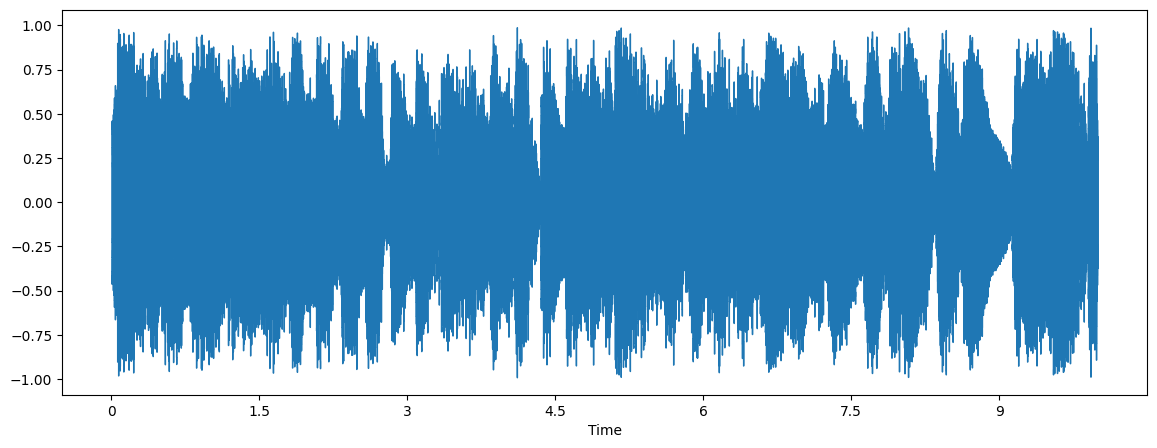

In [26]:
y,sr = librosa.load(random_file_name,sr=44100)
plt.figure(figsize=(14,5))
librosa.display.waveshow(y,sr=sr)

In [27]:
y.shape

(441000,)

In [28]:
from IPython.display import Audio
Audio(data=y,rate=sr)

In [29]:
#Plotting Melspectrogram of Entire Audio
def plot_melespectrogram(y,sr):
    #Compute spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y,sr=sr)
    #Convert to decibels (log scale)
    spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)
    #Visualize the spectrogram
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title("Spectrogram")
    plt.tight_layout()
    plt.show()

In [30]:
random_file_name = "/kaggle/input/nepali-mp3/new/Salaijo_22.wav"
y,sr = librosa.load(random_file_name,sr=44100)

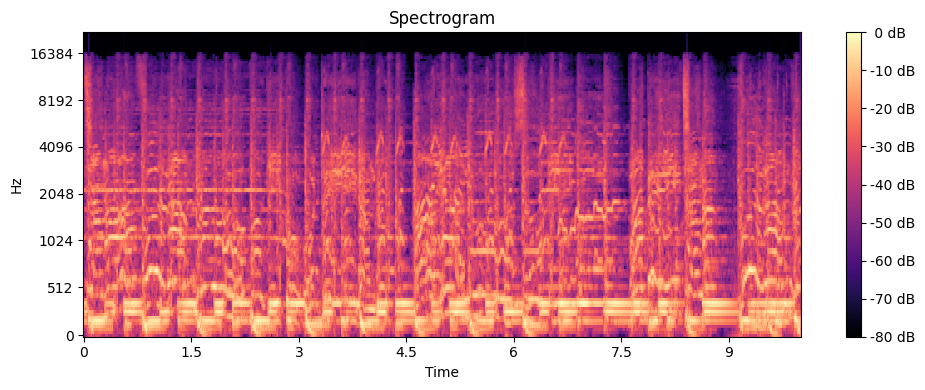

In [31]:
plot_melespectrogram(y,sr)


In [32]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define your folder structure
data_dir = "/kaggle/input/nepali-mp3/new"  # Directory containing all .wav files
classes = ['Asare', 'Gandharva', 'Jhyaure', 'Kumari', 'Maruni','Salaijo','Tharu']  # List of genres

# Load and preprocess audio data
def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
    data = []
    labels = []

    # Iterate over all files in the directory
    for filename in os.listdir(data_dir):
        if filename.endswith('.wav'):
            # Extract genre from the filename (e.g., "Asare_1.wav" -> "Asare")
            genre = filename.split('_')[0]

            # Check if the genre is in the classes list
            if genre in classes:
                file_path = os.path.join(data_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=44100)

                # Generate Mel Spectrogram for the entire 10-second audio
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)

                # Resize the Mel Spectrogram to the target shape
                mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)

                # Append data and labels to lists
                data.append(mel_spectrogram.numpy())  # Convert to numpy array
                labels.append(classes.index(genre))  # Use the index of the genre as the label

    # Convert lists to numpy arrays
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# Load and preprocess the data
data, labels = load_and_preprocess_data(data_dir, classes)

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=len(classes))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=42)



In [33]:
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (5600, 150, 150, 1), Test data shape: (1400, 150, 150, 1)


In [4]:
from tensorflow.keras import regularizers

# Define a simple CNN model with Batch Normalization, Dropout, and L2 Regularization
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 1)),  # Input shape for Mel Spectrogram
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization after Conv layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout after pooling

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization after Conv layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout after pooling

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization after Dense layer
    tf.keras.layers.Dropout(0.5),  # Dropout before the output layer

    tf.keras.layers.Dense(len(classes), activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,637,575 (40.58 MB)

 Trainable params: 10,637,127 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)

In [36]:
# # Train the model
# model.fit(X_train, Y_train, epochs=, batch_size=32, validation_data=(X_test, Y_test))

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)

# Train the model with Early Stopping
history = model.fit(
    X_train, Y_train,
    epochs=50,  # Set a high number of epochs (early stopping will stop training earlier if needed)
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.2949 - loss: 2.7967 - val_accuracy: 0.4671 - val_loss: 2.2204
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.5231 - loss: 1.9341 - val_accuracy: 0.5600 - val_loss: 2.0450
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6530 - loss: 1.7862 - val_accuracy: 0.6321 - val_loss: 2.2873
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.7353 - loss: 1.6908 - val_accuracy: 0.7029 - val_loss: 2.1610
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.7848 - loss: 1.6651 - val_accuracy: 0.5600 - val_loss: 2.7254
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.7792 - loss: 2.0077 - val_accuracy: 0.7186 - val_loss: 2.1236
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8373 - loss: 1.7384 - val_accuracy: 0.7429 - val_loss: 2.0719
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.8505 - loss: 1.6975 - val_accu

In [7]:
model.save("/kaggle/working/best.h5")

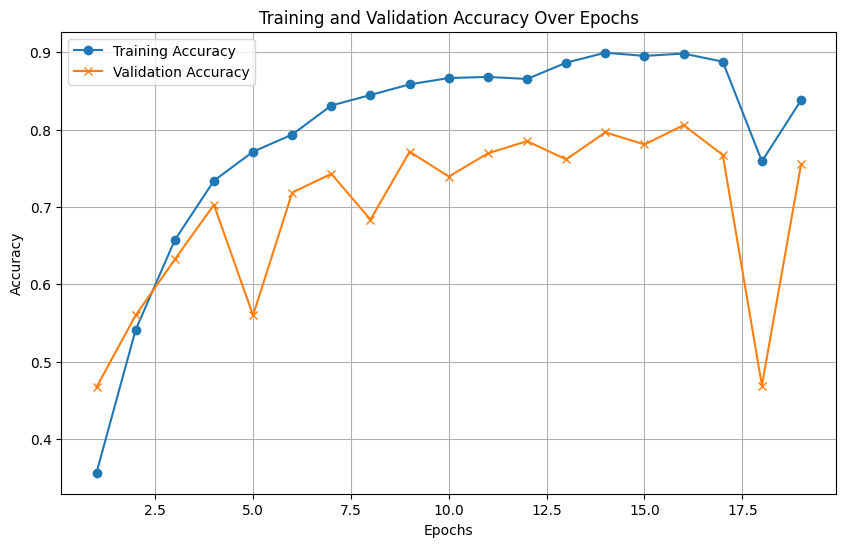

In [18]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy
def plot_accuracy(history):
    """
    Plots training and validation accuracy over epochs.
    :param history: History object from model.fit(), containing accuracy and validation accuracy values.
    """
    # Extract accuracy and validation accuracy
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(train_accuracy) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label="Training Accuracy", marker='o')
    plt.plot(epochs, val_accuracy, label="Validation Accuracy", marker='x')
    plt.title("Training and Validation Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the accuracy
plot_accuracy(history)


44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step


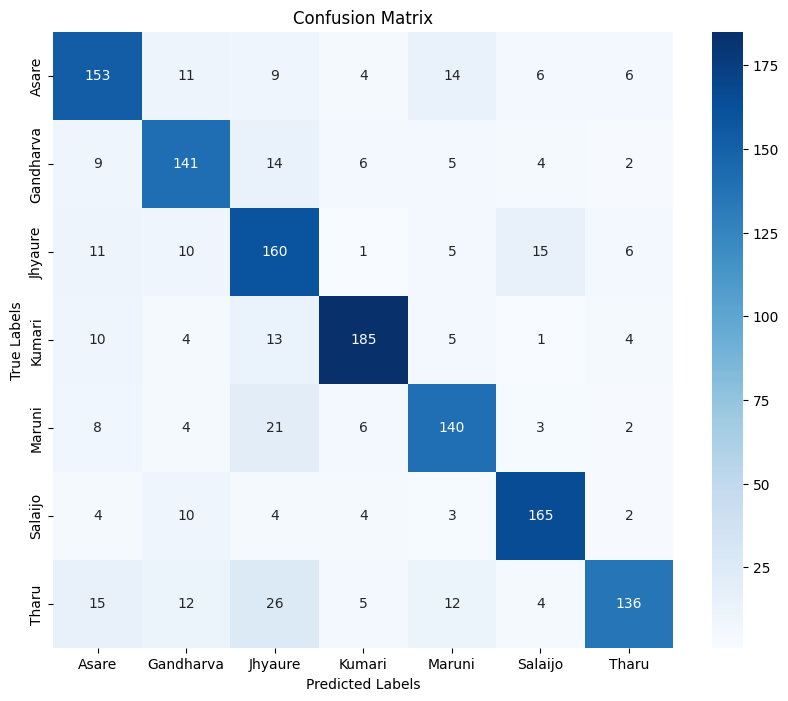

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to generate predictions for the test dataset
def generate_predictions(model, X_test):
    """
    Generates predictions for the test dataset.
    :param model: Trained model.
    :param X_test: Test data (Mel spectrograms).
    :return: Predicted class indices.
    """
    predictions = model.predict(X_test)
    predicted_class_indices = np.argmax(predictions, axis=1)
    return predicted_class_indices

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plots the confusion matrix.
    :param y_true: True labels.
    :param y_pred: Predicted labels.
    :param classes: List of class names.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Generate predictions for the test dataset
y_pred = generate_predictions(model, X_test)

# Convert one-hot encoded labels back to class indices
y_true = np.argmax(Y_test, axis=1)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, classes)

44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step


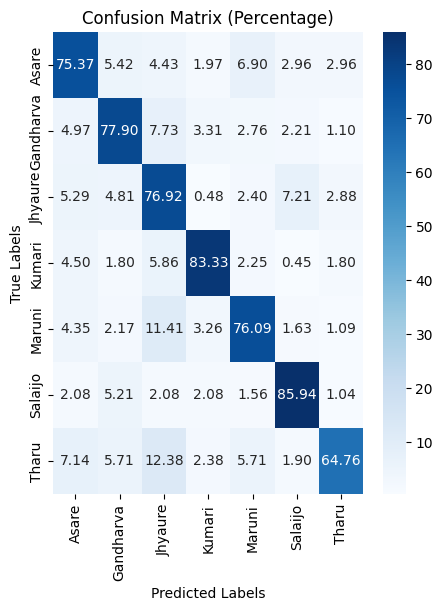

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to generate predictions for the test dataset
def generate_predictions(model, X_test):
    """
    Generates predictions for the test dataset.
    :param model: Trained model.
    :param X_test: Test data (Mel spectrograms).
    :return: Predicted class indices.
    """
    predictions = model.predict(X_test)
    predicted_class_indices = np.argmax(predictions, axis=1)
    return predicted_class_indices

# Function to plot the confusion matrix in percentages
def plot_confusion_matrix_percentage(y_true, y_pred, classes):
    """
    Plots the confusion matrix in percentages.
    :param y_true: True labels.
    :param y_pred: Predicted labels.
    :param classes: List of class names.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (true labels)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Plot the confusion matrix
    plt.figure(figsize=(5, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Percentage)")
    plt.show()

# Generate predictions for the test dataset
y_pred = generate_predictions(model, X_test)

# Convert one-hot encoded labels back to class indices
y_true = np.argmax(Y_test, axis=1)

# Plot the confusion matrix in percentages
plot_confusion_matrix_percentage(y_true, y_pred, classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Genre: Salaijo

Prediction Probabilities:
Asare: 0.0002
Gandharva: 0.0002
Jhyaure: 0.0026
Kumari: 0.0000
Maruni: 0.0033
Salaijo: 0.9936
Tharu: 0.0000


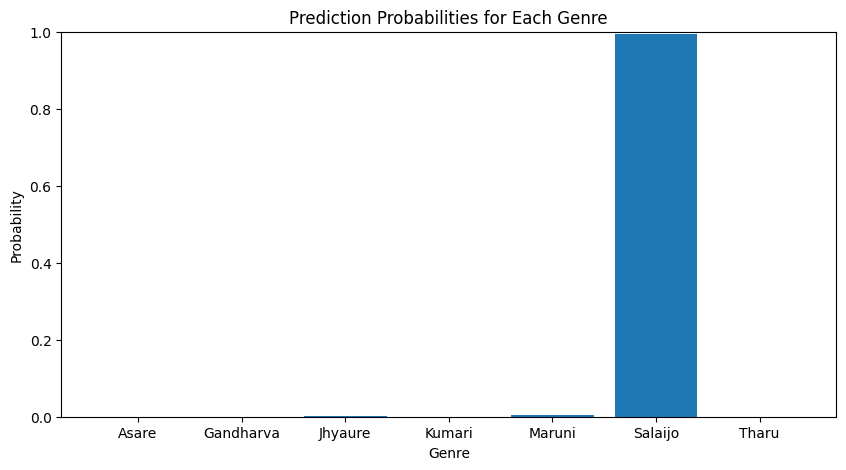

In [37]:
import matplotlib.pyplot as plt

# Function to preprocess a single audio file for prediction
def preprocess_audio_for_prediction(file_path, target_shape=(150, 150)):
    # Load the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)

    # Generate Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)

    # Resize the Mel Spectrogram to the target shape
    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)

    # Expand dimensions to match the model's input shape (batch_size, height, width, channels)
    mel_spectrogram = np.expand_dims(mel_spectrogram.numpy(), axis=0)

    return mel_spectrogram

# Path to the new audio file for prediction
new_audio_path = "/kaggle/input/unseen-mp3/test/Salaijo_unseen_03.wav"

# Preprocess the new audio file
preprocessed_audio = preprocess_audio_for_prediction(new_audio_path)

# Make a prediction
predictions = model.predict(preprocessed_audio)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Print the predicted genre
print(f"Predicted Genre: {predicted_class}")

# Print the prediction probabilities for all classes
print("\nPrediction Probabilities:")
for i, genre in enumerate(classes):
    print(f"{genre}: {predictions[0][i]:.4f}")

# Visualize the prediction probabilities
plt.figure(figsize=(10, 5))
plt.bar(classes, predictions[0])
plt.title("Prediction Probabilities for Each Genre")
plt.xlabel("Genre")
plt.ylabel("Probability")
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for probabilities
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Genre: Salaijo

Prediction Probabilities:
Asare: 0.0435
Gandharva: 0.0250
Jhyaure: 0.1555
Kumari: 0.0185
Maruni: 0.1099
Salaijo: 0.6209
Tharu: 0.0267


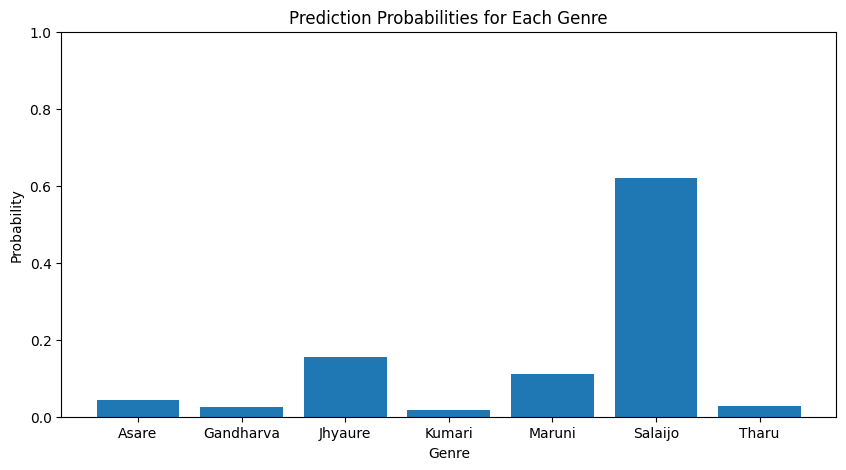

In [12]:
import matplotlib.pyplot as plt

# Function to preprocess a single audio file for prediction
def preprocess_audio_for_prediction(file_path, target_shape=(150, 150)):
    # Load the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)

    # Generate Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)

    # Resize the Mel Spectrogram to the target shape
    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)

    # Expand dimensions to match the model's input shape (batch_size, height, width, channels)
    mel_spectrogram = np.expand_dims(mel_spectrogram.numpy(), axis=0)

    return mel_spectrogram

# Path to the new audio file for prediction
new_audio_path = "/kaggle/input/nepali-mp3/new/Salaijo_304.wav"

# Preprocess the new audio file
preprocessed_audio = preprocess_audio_for_prediction(new_audio_path)

# Make a prediction
predictions = model.predict(preprocessed_audio)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Print the predicted genre
print(f"Predicted Genre: {predicted_class}")

# Print the prediction probabilities for all classes
print("\nPrediction Probabilities:")
for i, genre in enumerate(classes):
    print(f"{genre}: {predictions[0][i]:.4f}")

# Visualize the prediction probabilities
plt.figure(figsize=(10, 5))
plt.bar(classes, predictions[0])
plt.title("Prediction Probabilities for Each Genre")
plt.xlabel("Genre")
plt.ylabel("Probability")
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for probabilities
plt.show()

In [21]:
from tensorflow.keras.models import load_model
# Load the saved model
model = load_model('/kaggle/working/best.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predicted Genre: Salaijo

Prediction Probabilities:
Asare: 0.0904
Gandharva: 0.1090
Jhyaure: 0.1640
Kumari: 0.0732
Maruni: 0.0764
Salaijo: 0.3069
Tharu: 0.1800


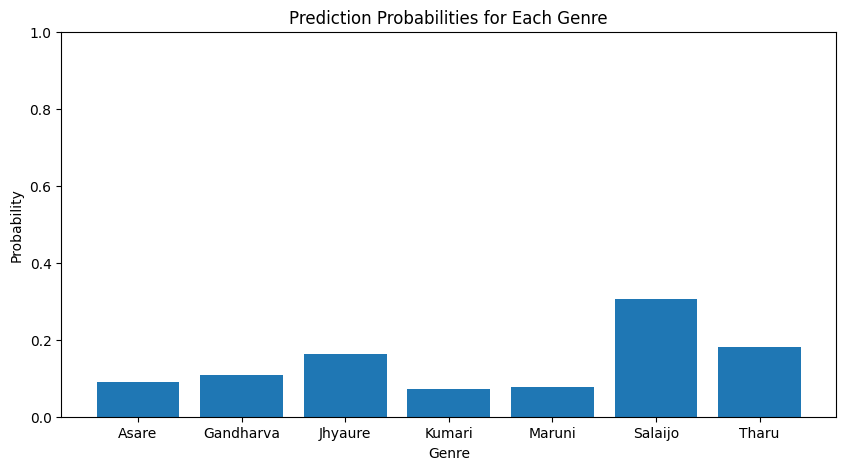

In [22]:
import matplotlib.pyplot as plt

# Function to preprocess a single audio file for prediction
def preprocess_audio_for_prediction(file_path, target_shape=(150, 150)):
    # Load the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)

    # Generate Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)

    # Resize the Mel Spectrogram to the target shape
    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)

    # Expand dimensions to match the model's input shape (batch_size, height, width, channels)
    mel_spectrogram = np.expand_dims(mel_spectrogram.numpy(), axis=0)

    return mel_spectrogram

# Path to the new audio file for prediction
new_audio_path = "/kaggle/input/nepali-mp3/new/Salaijo_304.wav"

# Preprocess the new audio file
preprocessed_audio = preprocess_audio_for_prediction(new_audio_path)

# Make a prediction
predictions = model.predict(preprocessed_audio)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class = classes[predicted_class_index]

# Print the predicted genre
print(f"Predicted Genre: {predicted_class}")

# Print the prediction probabilities for all classes
print("\nPrediction Probabilities:")
for i, genre in enumerate(classes):
    print(f"{genre}: {predictions[0][i]:.4f}")

# Visualize the prediction probabilities
plt.figure(figsize=(10, 5))
plt.bar(classes, predictions[0])
plt.title("Prediction Probabilities for Each Genre")
plt.xlabel("Genre")
plt.ylabel("Probability")
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for probabilities
plt.show()